<h1 style='color: green; font-size: 36px; font-weight: bold;'>Prediction Rental Prices: Brasilian houses to rent</h1>

## Importando Bibliotecas

In [1]:
# Import das bibliotecas e setting de configurações 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 
from sklearn.metrics import mean_absolute_error


import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 400)

%matplotlib inline
plt.rc('figure', figsize = (14, 6))

## Leitura dos dados

Importando o dataset "houses_to_rent_analisado", onde já foi realizado tratamento dos dados:

In [2]:
dataset = pd.read_csv('houses_to_rent_analisado.csv', sep=',')

Detalhando algumas informações através do metodo info:

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10660 entries, 0 to 10659
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            10660 non-null  object
 1   area            10660 non-null  int64 
 2   rooms           10660 non-null  int64 
 3   bathroom        10660 non-null  int64 
 4   parking spaces  10660 non-null  int64 
 5   floor           10660 non-null  int64 
 6   animal          10660 non-null  int64 
 7   furniture       10660 non-null  int64 
 8   hoa             10660 non-null  int64 
 9   rent amount     10660 non-null  int64 
 10  property tax    10660 non-null  int64 
 11  fire insurance  10660 non-null  int64 
 12  total           10660 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.1+ MB


## Matriz de Correlação

<AxesSubplot:>

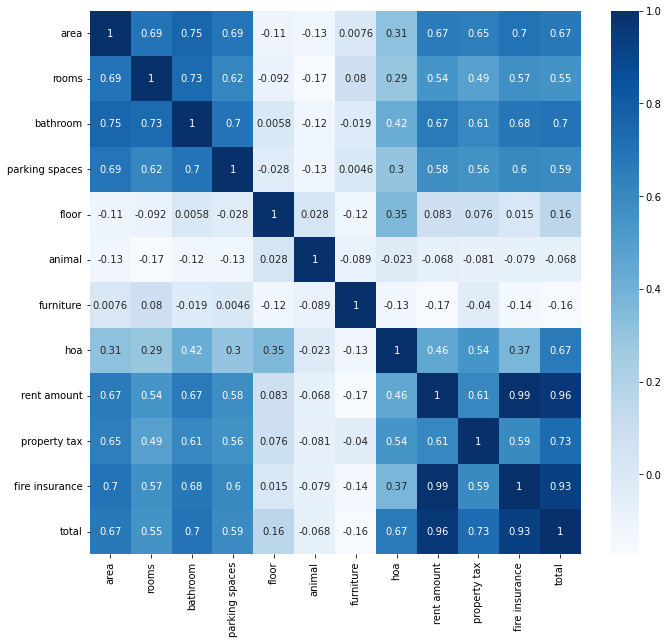

In [4]:
corr = dataset.drop(['city'], axis=1).corr()

plt.figure(figsize=(11,10))

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="Blues", annot=True)

A coluna 'total'(valor total de aluguel), é formado a partir da soma de quatro outras colunas ('hoa', 'rend amount', 'property tax', 'fire insurance'). Então, como estamos querendo prever os valores dos imoveis, não teriamos este tipo informações, logo não utiliizaremos estas colunas por esses dois motivos.

As colunas 'animal' e 'furniture' possuiem uma baixa correlação com o 'total', logo, não utilizaremos estas features para criação do modelo. 

Retirando as colunas que não serão utilizadas:

In [5]:
dataset.loc[:,['area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'total']].corr().round(4)

,area,rooms,bathroom,parking spaces,floor,total
area,1.0000,0.6938,0.7543,0.6897,-0.1105,0.6732
rooms,0.6938,1.0000,0.7341,0.6165,-0.0923,0.5525
bathroom,0.7543,0.7341,1.0000,0.6975,0.0058,0.6976
parking spaces,0.6897,0.6165,0.6975,1.0000,-0.0280,0.5901
floor,-0.1105,-0.0923,0.0058,-0.0280,1.0000,0.1615
total,0.6732,0.5525,0.6976,0.5901,0.1615,1.0000


## Variável Dependente X Variáveis Explicativas

Utilizaremos o gráfico de dispersão entre as variáveis do dataset para ter uma visualização gráfica do comportamento variável independentes sobre a variável dependente

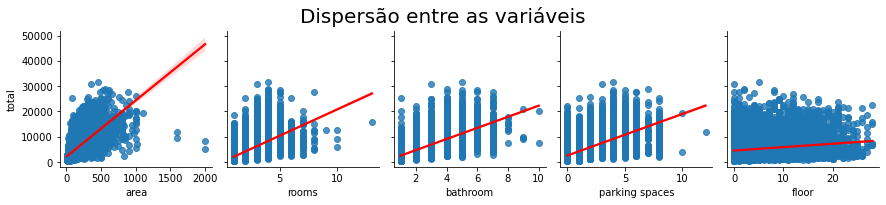

In [6]:
ax = sns.pairplot(dataset.loc[:,['area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'total']],
                     y_vars='total', 
                     x_vars=['area', 'rooms', 'bathroom', 'parking spaces', 'floor'],
                     kind='reg', 
                     plot_kws={'line_kws':{'color':'red'}})
ax.fig.suptitle("Dispersão entre as variáveis", fontsize=20, y=1.1) # o argumento y indica a posição do titulo em relação ao eixo y
plt.show()

Através do gráfico é possível perceber que todas as variáveis independentes possui uma tendência positiva.  A 'area' possui uma tendencia mais proxima de ser uma relação linear em relação as outras, já que seus dados são menos dispersos.

## Codificação categórica

A feature 'city' é uma variável categórica, logo, não pode ser utilizada como feature para criação de um modelo de Machine Learning. Para poder utilizar esta feature vai ser aplicado a One-hot encoding.

In [7]:
encoder = ce.OneHotEncoder(use_cat_names=True)
df_encoded = encoder.fit_transform(dataset[['city']])
df_encoded.head()

,city_São Paulo,city_Porto Alegre,city_Rio de Janeiro,city_Campinas,city_Belo Horizonte
0,1,0,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0


Concatenando o dataset das cidades com o cojunto de dados e dropando a feature 'city':

In [8]:
dataset = dataset.drop('city',axis=1)
dataset = pd.concat([dataset, df_encoded], axis=1)
dataset.head()



,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total,city_São Paulo,city_Porto Alegre,city_Rio de Janeiro,city_Campinas,city_Belo Horizonte
0,70,2,1,1,7,0,0,2065,3300,211,42,5618,1,0,0,0,0
1,320,4,4,0,20,0,1,1200,4960,1750,63,7973,1,0,0,0,0
2,80,1,1,1,6,0,1,1000,2800,0,41,3841,0,1,0,0,0
3,51,2,1,0,2,0,1,270,1112,22,17,1421,0,1,0,0,0
4,25,1,1,0,1,1,1,0,800,25,11,836,1,0,0,0,0


## Padronização do Conjunto de Dados

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10660 entries, 0 to 10659
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   area                 10660 non-null  int64
 1   rooms                10660 non-null  int64
 2   bathroom             10660 non-null  int64
 3   parking spaces       10660 non-null  int64
 4   floor                10660 non-null  int64
 5   animal               10660 non-null  int64
 6   furniture            10660 non-null  int64
 7   hoa                  10660 non-null  int64
 8   rent amount          10660 non-null  int64
 9   property tax         10660 non-null  int64
 10  fire insurance       10660 non-null  int64
 11  total                10660 non-null  int64
 12  city_São Paulo       10660 non-null  int64
 13  city_Porto Alegre    10660 non-null  int64
 14  city_Rio de Janeiro  10660 non-null  int64
 15  city_Campinas        10660 non-null  int64
 16  city_Belo Horizonte  1

Sendo os dados de ordens de magnitude diferente, iremos normalizar todo o conjunto de dados para evitar que algumas features dominem a função objetivo e atrapalhe o estimador.

Instânciando a classe StandardScaler:

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1)) 

Serando as features que serão utilizadas para criação do modelo:

In [13]:
features = dataset.loc[:,['area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'city_São Paulo', 'city_Porto Alegre', 'city_Rio de Janeiro', 'city_Campinas', 'city_Belo Horizonte']]
features_list = list(features.columns)

Calculando a média e std a serem usados ​​para dimensionamento posterior:

In [14]:
scaler.fit(features)

MinMaxScaler()

In [15]:
features_norm = scaler.transform(features)

## Separando as variáveis depdendentes e independetes 

Separando as variáveis dependentes (y) e independetes (X) em uma series e um dataframe, respectivamente, para armazenar os dados:

In [16]:
X = features_norm
y = dataset['total']

Criando os datasets de treino e de teste:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2811)

Foi utilizando 20% dos dados que será utilizado apara teste do modelo, enquanto os outros 80% será utilizado para realizar o treinamento. Definido uma seed de gerador de números aleatórios (2811) para seja possível comparar resultados.

In [18]:
print(f'Tamanhos X_train: {X_train.shape}')
print(f'Tamanhos y_train: {y_train.shape}')
print(f'Tamanhos X_test: {X_test.shape}')
print(f'Tamanhos y_test:  {y_test.shape}')

Tamanhos X_train: (8528, 10)
Tamanhos y_train: (8528,)
Tamanhos X_test: (2132, 10)
Tamanhos y_test:  (2132,)


## Regressão Linear (Linear Regression)

Instânciando a classe LinearRegression:

In [19]:
modelo_regressao_linear = LinearRegression()

Utilizando o método fit do objeto "modelo_regressao_linear_simples" para estimar nosso modelo linear utilizando os dados de treino:

In [20]:
modelo_regressao_linear.fit(X_train, y_train)

LinearRegression()

Obtendo o coeficiente de determinação (R²) do modelo estimado com os dados de treino:

In [21]:
print(f'R² = {modelo_regressao_linear.score(X_train, y_train):.2f}')

R² = 0.61


Gerando previsões para os dados de teste (X_test) utilizando o método predict do objeto "modelo_regressao_linear_simples":

In [22]:
y_previsto = modelo_regressao_linear.predict(X_test)

Obtendo o coeficiente de determinação (R²) para as previsões do nosso modelo


In [23]:
print(f'R²(previsto) = {metrics.r2_score(y_test, y_previsto):.2f}')

R²(previsto) = 0.58


Analisando o desempenho através do coeficiente de determinação mostra que o modelo de regressão linear não se ajustou aos dados de forma consistente, já que ficou muito distânte do valor 1.

Obtendo o intercepto do modelo:

In [24]:
intercepto = modelo_regressao_linear.intercept_
intercepto

537.9714095150839

obtendo os coeficientes de regressão do modelo:

In [25]:
coefs = modelo_regressao_linear.coef_
coefs

array([24021.02566519,  1030.30160931,  9189.47989928,  3786.53364521,
        4234.73712633,   929.46124702,  -425.36319346,   967.10139434,
        -870.73358525,  -600.46586265])

Criando um DataFrame para armazenar os coeficientes do modelo:

In [27]:
coeficiente_modelo_regressao_linear = pd.DataFrame(data=np.append(intercepto, coefs), 
                                                            index=['intercepto', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'city_São Paulo', 'city_Porto Alegre', 'city_Rio de Janeiro', 'city_Campinas', 'city_Belo Horizonte'],
                                                            columns=['parametros'])
coeficiente_modelo_regressao_linear

,parametros
intercepto,537.971410
area,24021.025665
rooms,1030.301609
bathroom,9189.479899
parking spaces,3786.533645
floor,4234.737126
city_São Paulo,929.461247
city_Porto Alegre,-425.363193
city_Rio de Janeiro,967.101394
city_Campinas,-870.733585


## Random Florest Regressor

Com a floresta aleatória, também combinarei a abordagem de validação cruzada K-Fold (com K = 10), o que significa que dividiremos os dados em dez partes, treinaremos 9 partes e testaremos com a 10ª parte e usaremos uma fatia diferente dessa torta de dez peças como os dados de teste em cada iteração, maximizando o tamanho do nosso conjunto de dados para obter melhores resultados.

In [28]:
kf = KFold(n_splits=10,random_state=42,shuffle=True)

In [29]:
accuracies = []

In [30]:
for train_index, test_index in kf.split(features):
    data_train = X[train_index]
    target_train = y[train_index]

    data_test = X[test_index]
    target_test  = y[test_index]

    rf = RandomForestRegressor(n_estimators = 400, 
                               random_state = 42, 
                               criterion = 'mse',
                               min_samples_leaf = 1,
                               min_samples_split= 2,
                               max_features = 'sqrt',
                               bootstrap=False,
                               max_depth = None)

    rf.fit(data_train, target_train)

    predictions = rf.predict(data_test)

    errors = abs(predictions - target_test)

    print('Mean Absolute Error:', round(np.mean(errors), 2))

    mape = 100 * (errors / target_test)
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')

    accuracies.append(accuracy)


average_accuracy = np.mean(accuracies)
print('Average accuracy:', average_accuracy)


Mean Absolute Error: 1730.89
Accuracy: 64.38 %.
Mean Absolute Error: 1659.66
Accuracy: 66.79 %.
Mean Absolute Error: 1662.7
Accuracy: 63.95 %.
Mean Absolute Error: 1768.58
Accuracy: 61.72 %.
Mean Absolute Error: 1756.56
Accuracy: 64.07 %.
Mean Absolute Error: 1748.4
Accuracy: 65.17 %.
Mean Absolute Error: 1724.83
Accuracy: 63.45 %.
Mean Absolute Error: 1648.03
Accuracy: 66.63 %.
Mean Absolute Error: 1705.97
Accuracy: 64.26 %.
Mean Absolute Error: 1668.77
Accuracy: 63.35 %.
Average accuracy: 64.3766169991076


## Conclusão

Removendo as colunas de custos do dataset para criação do modelo, deixando apenas as caracteristicas do imóvel, a previsibilidade do modelo atinge valores muitos baixos para as duas técnicas de machine learning abordada. Para uma abordagem mais eficiente, no entanto, é necessário considerar um número maior de features ou um model tuning para as técnicas aqui utilizadas.